# Coursera_Capstone
<p> This project is part of the IBM Data Science Professional Certification provided by Coursera and its main objective is to apply data science concepts to analyze a real-world scenario. </p>

# 1.Introduction
<p>
One of the current concerns of the Seattle Department of Transportation is to find solutions that can minimize the number of car accidents, as well as fatalities, injuries and damages due to traffic accidents, however, before solving a problem it is extremely important to study it and understand it in full. In this context, all relevant information of occurrences is recorded and maintained by the department for the access of all researchers.

This project intends to use these records to analyze all the collisions recorded from 2003 to October 2020 in order to build a Machine Learning Model that allows the severity of an accident to be classified by its characteristics.
</p>

<p> To achieve the objective, the project applies data science concepts such as Machine Learning and Data Visualization under the CRISP-DM methodology, which is a model focused on communication, flexibility and iteration at each stage of the project to keep it on track right. The project was designed and structured based on 6 stages of the CRISP-DM methodology namely,Business understanding, Data understanding, Data preparation, Modeling, Evaluation and Implementation.</p>

# 2.Data Understanding

<p>
The data set used in this project is available in a comma-separated values (CSV) file format and has been downloaded from <a href="https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0?geometry=-122.326%2C47.592%2C-122.318%2C47.594" target="_blank">Seattle Open GeoData Portal</a> and includes all types of collisions since 2004 to Present. The dataset metadata was found at <a href="https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf" target="_blank"> Department of Transportation Seattle</a>.
The dataset contains 221738 rows/registers and 40 columns/fields. The dataset contains columns with 3 diferent type of values, float64, object and Int64.
</p>


# 3.Data Preparation and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

#!conda install seaborn -y
import seaborn as sns

#### Loading Data

In [ ]:
#!wget -O Collisions.csv "https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv"

In [2]:
df_raw = pd.read_csv('Collisions.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221738 entries, 0 to 221737
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                214260 non-null  float64
 1   Y                214260 non-null  float64
 2   OBJECTID         221738 non-null  int64  
 3   INCKEY           221738 non-null  int64  
 4   COLDETKEY        221738 non-null  int64  
 5   REPORTNO         221738 non-null  object 
 6   STATUS           221738 non-null  object 
 7   ADDRTYPE         218024 non-null  object 
 8   INTKEY           72027 non-null   float64
 9   LOCATION         217145 non-null  object 
 10  EXCEPTRSNCODE    101335 non-null  object 
 11  EXCEPTRSNDESC    11785 non-null   object 
 12  SEVERITYCODE     221737 non-null  object 
 13  SEVERITYDESC     221738 non-null  object 
 14  COLLISIONTYPE    195287 non-null  object 
 15  PERSONCOUNT      221738 non-null  int64  
 16  PEDCOUNT         221738 non-null  int6

<b>About data...</b><br>
1 - There is 221738 records in 40 columns and not all of columns have the same number of records.<br>
2 - The data contain categorical and continuos values distribuided in float64(5), int64(12), object(23).

<b> Balancing data </b>
<p>
During Data Understanting some other projects were studied and was possible to understand wich kind of variable can be useful in this kind of analysis and that is good  before start balancing the data decide first  columns that contain information that apparently can be useful for the analysis goals.
</p>

In [3]:
df = df_raw[['X','Y','SEVERITYCODE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT',
            'VEHCOUNT','INJURIES','SERIOUSINJURIES','FATALITIES','WEATHER','ROADCOND','SPEEDING','JUNCTIONTYPE','UNDERINFL','LIGHTCOND','HITPARKEDCAR','PEDROWNOTGRNT','INATTENTIONIND','INCDATE','SEVERITYDESC']]

In [4]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df= missing_df[missing_df[0]>0]
missing_df

,index,0
0,X,7478
1,Y,7478
2,SEVERITYCODE,1
3,COLLISIONTYPE,26451
11,WEATHER,26641
12,ROADCOND,26560
13,SPEEDING,211802
14,JUNCTIONTYPE,11979
15,UNDERINFL,26431
16,LIGHTCOND,26730


#### Handling with missing values <br>

During data understanding was noticed that:<br>
1 - The values of column <code>SPEEDING</code> behave as boolean where value <code>Y</code> represents <code>TRUE</code> and  <code>(empty)</code> represents <code>FALSE</code>.<br>
2 - The values of <code>SEVERITYCODE</code>  can be <code>1,2,3,2b</code> and value <code>0</code> means unknown<br>
3 - All columns with values <code>Y</code> and <code>N</code> have boolean behave<br>
4 - Columns use values <code>Unknown</code> and <code>Other</code> also to express missing information.<br>

<br>
All this finding was applied before start droping data.

In [5]:
df["SEVERITYCODE"].replace('0', np.nan, inplace=True)
df["SEVERITYCODE"].replace('2b', 4, inplace=True)
df["SEVERITYCODE"] = df["SEVERITYCODE"].apply(pd.to_numeric, downcast='integer', errors='coerce')
df["SPEEDING"].replace(np.nan,0 , inplace=True)
df["PEDROWNOTGRNT"].replace(np.nan,0 , inplace=True)
df["INATTENTIONIND"].replace(np.nan,0 , inplace=True)
df.replace({"Y": 1, '1':1} , inplace=True)
df.replace({"N": 0, '0':0} , inplace=True)
df.replace("Unknown", np.nan , inplace=True)
df.replace("Other", np.nan , inplace=True)


df['MONTH']=pd.to_datetime(df['INCDATE']).dt.month
df['DAYOFWEEK']=pd.to_datetime(df['INCDATE']).dt.dayofweek
df.drop(['INCDATE'],axis=1, inplace=True)


In [ ]:
print('Before', df.shape)
df.dropna(axis=0, inplace=True)
print('After', df.shape)
df.dtypes

In [6]:
df_clean = df
df_clean.head(10)

,X,Y,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,...,SPEEDING,JUNCTIONTYPE,UNDERINFL,LIGHTCOND,HITPARKEDCAR,PEDROWNOTGRNT,INATTENTIONIND,SEVERITYDESC,MONTH,DAYOFWEEK
0,-122.356511,47.517361,1.0,Angles,2,0,0,2,0,0,...,0,At Intersection (intersection related),0.0,Daylight,0,0,0,Property Damage Only Collision,1,6
1,-122.361405,47.702064,1.0,Rear Ended,2,0,0,2,0,0,...,0,Mid-Block (not related to intersection),0.0,Dusk,0,0,1,Property Damage Only Collision,4,0
2,-122.317414,47.664028,2.0,Head On,2,0,0,2,1,0,...,0,Mid-Block (not related to intersection),0.0,Dark - Street Lights On,0,0,0,Injury Collision,3,6
3,-122.318234,47.619927,2.0,Pedestrian,3,1,0,1,1,0,...,0,At Intersection (intersection related),0.0,Dark - Street Lights On,0,0,0,Injury Collision,1,0
4,-122.351724,47.560306,2.0,NaN,2,0,0,1,1,0,...,1,Mid-Block (not related to intersection),0.0,Dark - Street Lights On,0,0,0,Injury Collision,12,4
5,-122.333067,47.544302,1.0,Rear Ended,2,0,0,2,0,0,...,0,Mid-Block (not related to intersection),0.0,Daylight,0,0,0,Property Damage Only Collision,8,3
6,-122.338543,47.616874,1.0,Cycles,3,0,1,1,0,0,...,0,Mid-Block (not related to intersection),0.0,Daylight,0,0,1,Property Damage Only Collision,8,3
7,NaN,NaN,1.0,Parked Car,0,0,0,2,0,0,...,0,Mid-Block (not related to intersection),0.0,Daylight,0,0,0,Property Damage Only Collision,8,0
8,-122.360959,47.571594,4.0,Rear Ended,3,0,0,3,3,1,...,0,Mid-Block (not related to intersection),0.0,Daylight,0,0,1,Serious Injury Collision,7,2
9,-122.336856,47.655652,1.0,Rear Ended,2,0,0,2,0,0,...,0,Mid-Block (but intersection related),0.0,Dusk,0,0,1,Property Damage Only Collision,8,1


### Data visualization and pre-processing 

Target <code>SEVERITY</code>

In [ ]:
ax=plt.subplots(figsize=(11,8))
sns.set(style='darkgrid')
sns.countplot('SEVERITYDESC',data=df_clean,ax=ax[1],order=df_clean['SEVERITYDESC'].value_counts().index)
ax[1].set_title('Distribuition of Severity')
plt.show()

#### Continuos Features

In [7]:
continuous_features = [col for col in df_clean.columns if df_clean[col].dtype=='float64' or df_clean[col].dtype=='int64']

In [ ]:

plt.figure(figsize=(16,13))
matrix = np.triu(df_clean[continuous_features].corr())
sns.heatmap(df_clean[continuous_features].corr(), annot=True, mask=matrix)


As can be seen, the most correlated variable to the target is <code>INJURIES</code>, followed by <code>SERIOUSINJURIES</code> and <code>PEDCOUNT</code>.

Is important to analysi each of this variables separately to understand the importance to accident classification. The better way to do that is using visualization resources.


In [ ]:
sns.set_theme(); np.random.seed(0)
sns.jointplot(x=df_clean.X.values,y=df_clean.Y.values,height=10, data=df_clean, hue="SEVERITYDESC")
sns.color_palette("dark", 10)
plt.ylabel('Latitude', fontsize=12)
plt.xlabel('Longitude', fontsize=12)
plt.show()
#plt.savefig('severity_geo_distribuition.png')

Looking at the geodistribution map, we can see that the accident's Severity distribution has almost the same proportions in terms of occurrence. Therefore, we can assume that the site has a weak impact to determine the severity of the accident.

Continuing with other variables

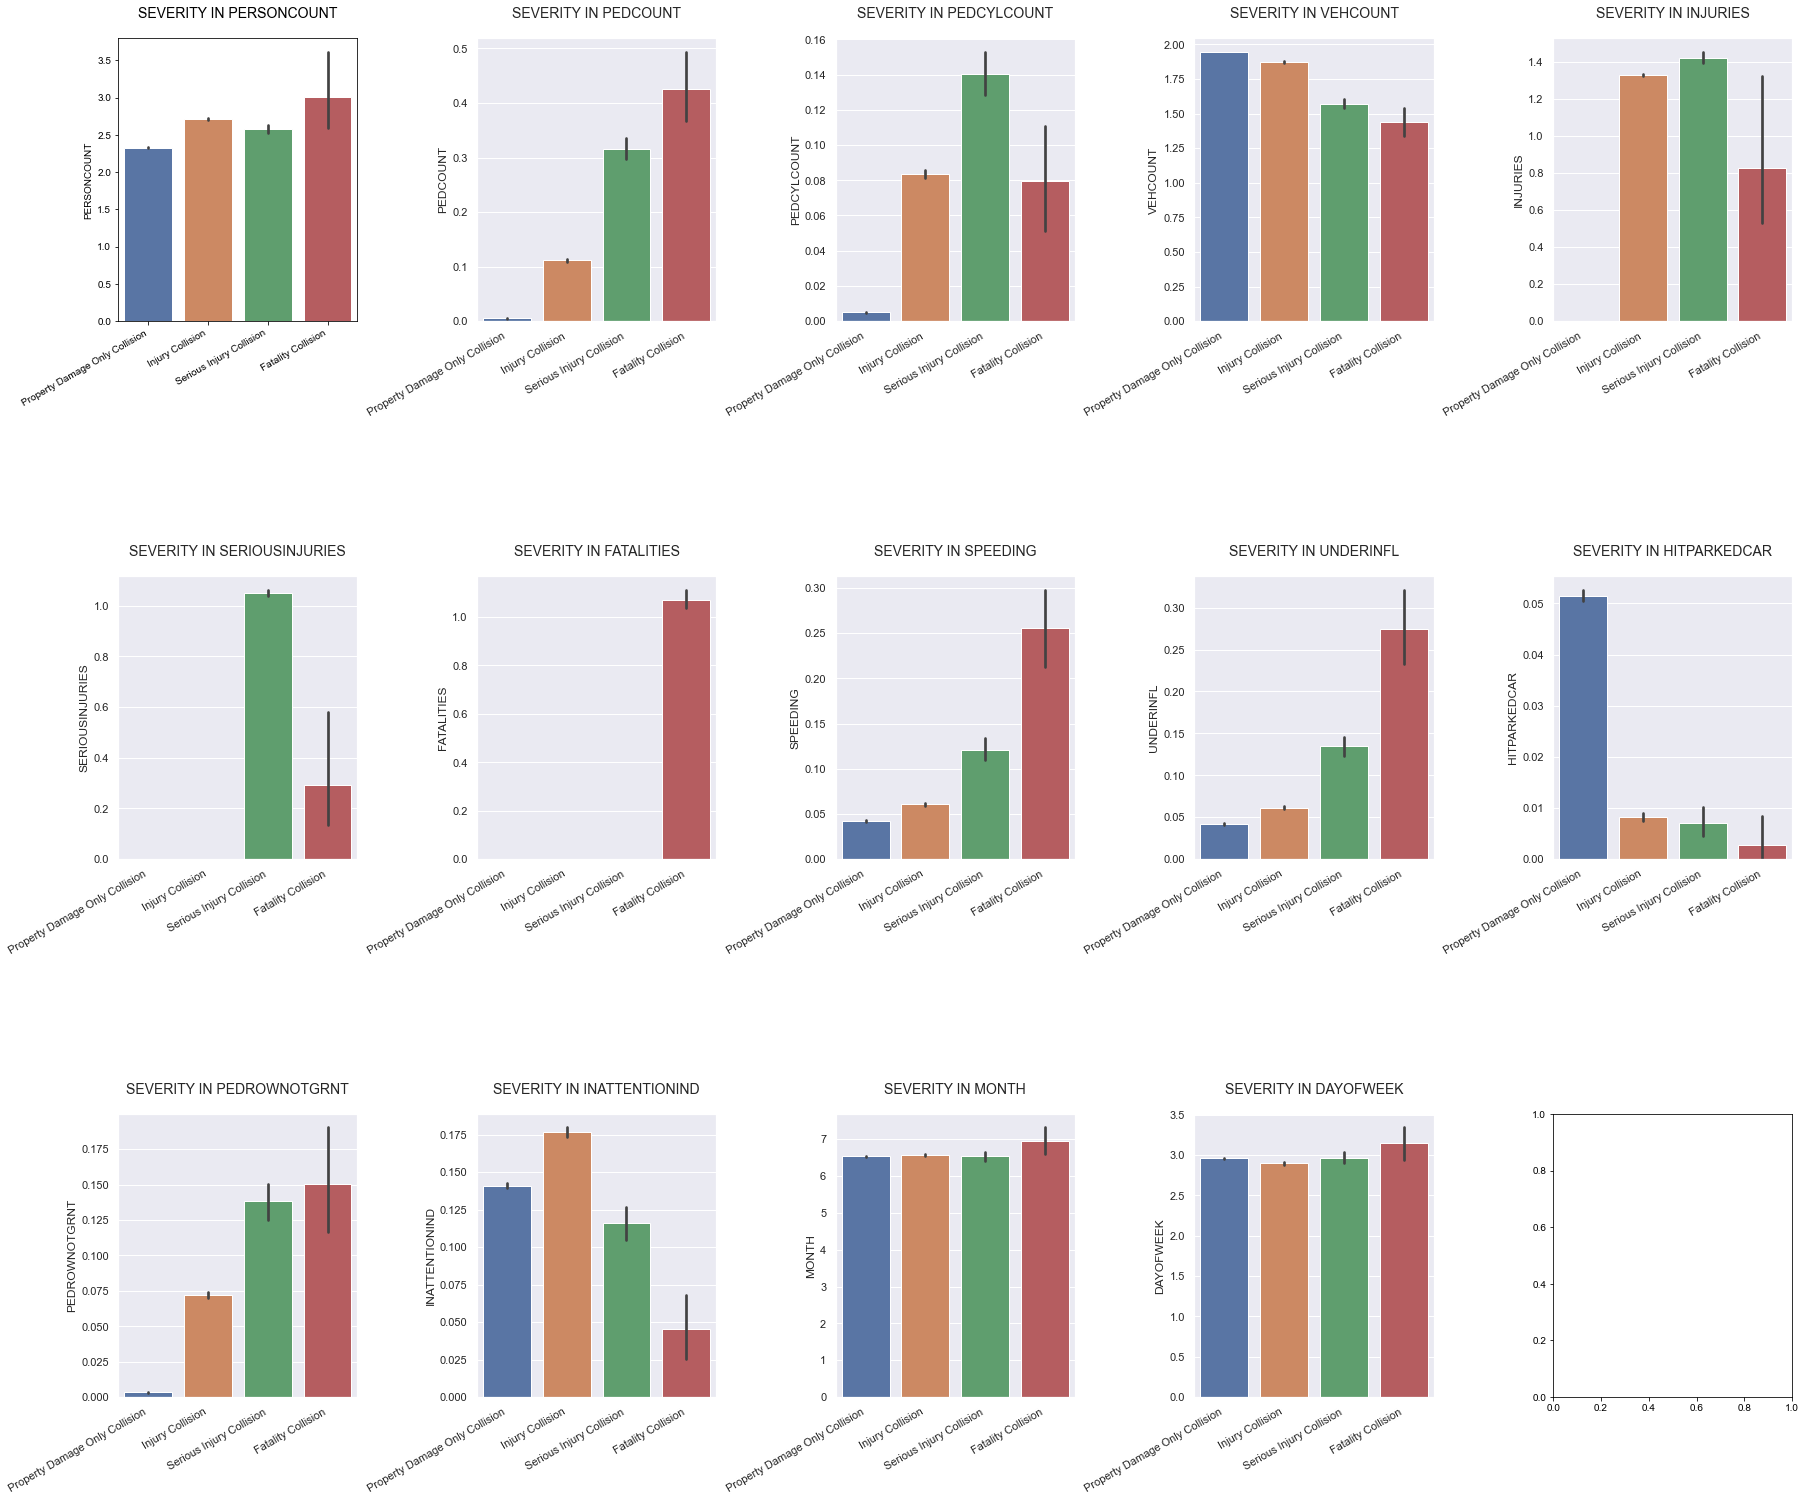

In [8]:
continuous_features.remove('X')
continuous_features.remove('Y')
continuous_features.remove('SEVERITYCODE')


fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(30,25))
plt.subplots_adjust(hspace=.9,wspace = 0.5)
for i, feature in enumerate(continuous_features, 1):    
    plt.subplot(3, 5, i)
    sns.set(style='darkgrid')
    ax = sns.barplot(x = 'SEVERITYDESC', y = feature, data = df_clean)
    plt.xticks(rotation=30, horizontalalignment='right',fontweight='light') 
    plt.title('SEVERITY IN {}'.format(feature), size=14, y=1.05)
    ax.set_xlabel('')
#fig.suptitle('SEVERITY VS CONTINUOUS VARIABLES',y=.02)
plt.show()
#plt.savefig('severity_distribuition_continuous.png')


There a very insteresting connections between the potencial features and the target. Analysing each of the graphs we can se that:<br>
<ul>
    <li><p>INJURIES - Accident involving a high number of <code>INJURIES</code>  tends to be classified as 
    <b>Serious Injury Colision</b> and with thw lower as  <b>Property Damage Only Collision</b>. This is a good feature to the model</p>
    </li><br>
    <li>SERIOUSINJURIES - Accidents envloving serious injuries tends to be classified as <b>Serious Injury Colision</b> or 
        <b>Fatality Collision</b>. 
    </li><br>
    <li>SPEEDING or UNDERINFL or PEDCOUNT - Accidents caused by high speed or driving under the influence of drugs or even accidents involving a   considerable number of pedestrians tend to be classified as <b> Collision Fatality </b>. The classification tends to be less severe when these variables reduces the value.
    </li><br>
    <li>
        PEDCYLCOUNT - Accident envloving high number of pedestrians with bicycle tend to be classified as <b> Serious Injury Collision</b> it makes sense because whenever a car collides with a motorcyclist the cyclist is more likely to suffer serious injuries and can sometimes be fatal and when it happens is classificaed as <b> Fatality Collision</b> 
    </li><br>
    <li> FATALITIES - Accidents with <b>Fatalies<b> regardless the quantity is classificated as <b>Fatality Collision<b/>
    </li><br>
    <li> PERSONCOUNT - Accident envloving high number of person tend to be classified as <b> Fatalies Collision</b> it because in most of these casesthe probability of at least one Fatality is higer.
    </li><br>
    <li> <p>VHECOUNT - Accident envloving high number of Vehicles tend to be classified as <b> Property Damage Only Collision</b>.that probably
it happens because other cars around the crash site suffer minor damage caused by the collision inertia, and there have been no human victims because the cars are empty and parked. 
But it is not so linear, if combined with other variables such as FATALITIES, it is automatically classified as <b> Fatality Collision</b>.</p>
    </li>   
</ul>


### Categorical Features

In [ ]:
categorical_features = [col for col in df_clean.columns if df_clean[col].dtype=='object']
categorical_features.remove('SEVERITYDESC')
categorical_features

Lets explore the distirbuiton of each variable in accident severity so far.

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(30, 24))
plt.subplots_adjust(hspace=1,wspace = 0.5)
for i, feature in enumerate(categorical_features, 1):    
    plt.subplot(3, 2, i)
    sns.set(style='darkgrid')
    ax = sns.countplot(x=feature, hue = 'SEVERITYDESC', data = df_clean)
    plt.xticks(rotation=30, horizontalalignment='right',fontweight='light') 
    plt.title('SEVERITY IN {}'.format(feature), size=14, y=1.05)
    plt.legend(bbox_to_anchor=(1.0, 0.7),borderaxespad=0.5)
    ax.set_xlabel('')
fig.suptitle('SEVERITY VS CATEGORICAL VARIABLES',y=.95, fontsize=16)
plt.savefig('severity_distribuition_categorical.png')
#plt.show()

As we can see the categorical variables (just a few values ​​of each variable) only have an impact on the classification of accidents <b>Property Damage Collision</b> and <b>Injury Collision</b>. 

In [ ]:
feautures = ['SEVERITYCODE']+continuous_features+categorical_features

df_cleaned = pd.get_dummies(df_clean[feautures], columns=categorical_features, drop_first=True)

df_corr = pd.DataFrame(df_cleaned.corr()['SEVERITYCODE'].sort_values(ascending=False)).reset_index()
df_corr.columns = ['features','correlation']
df_corr[1:]

Converting Categorical features in continuous create a lot of variables to the data set, but as we saw when we was observing categorical variables not all of categories values have important impact to classificate accident severity, therefore, all the variables with -0.009 < correlaction < 0.009 will be droped because it means that there is no historical data enought to help us classifying an accident based in this value.

In [ ]:
df_corr = df_corr.loc[(df_corr['correlation'] > 0.05) | (df_corr['correlation'] <-0.05)]
df_corr[1:]
feautures = df_corr['features'].values[1:].tolist()
feautures

Setting the Features

In [ ]:
X = df_cleaned[feautures]
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[:5]

Setting the Target

In [ ]:
y = df_cleaned['SEVERITYCODE']
y[:5]

# 4. Modeling and Evaluation

<p>
After processing the dataset and find the features, now is time to build the model to predict the accident severity based on data historical, to achieve this will be used the train split test approach and also be used the KNN, Decision Tree Classification and Logistic Regression as   classification models. 

<code> accuracy.score</code> and <code>f1score.score</code> to evaluate model accuracy.
</p>

###  Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

lr_pred = LR.predict(X_test)
lr_acc = round(accuracy_score(y_test, lr_pred)*100,2)
lr_f1 = round(f1_score(y_test, lr_pred, average='weighted')*100,2)
 
print("Test Accurancy: %.1f%%"% (lr_acc))
print("Test F1 Accurancy: %.1f%%"% (lr_f1))


### Decision Tree Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dtc.fit(X_train,y_train)

dtc_pred = dtc.predict(X_test)
dtc_acc = round(accuracy_score(y_test, dtc_pred)*100,2)
dtc_f1 = round(f1_score(y_test, dtc_pred, average='weighted')*100,2)

print("Decision Tree Classification Accurracy %.1f%%"% (dtc_acc))
print("Decision Tree Classification f1 Accurracy %.1f%%"% (dtc_f1))


### K-Nearest Neighbors - KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n, n_jobs=-1).fit(X_train,y_train)
    
    knn_pred=neigh.predict(X_test)
    
    mean_acc[n-1] = accuracy_score(y_test, knn_pred)
    
    std_acc[n-1]=np.std(knn_pred==y_test)/np.sqrt(knn_pred.shape[0])

mean_acc

In [ ]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [ ]:
knn_acc = round(mean_acc.max()*100,1)
k = mean_acc.argmax()+1
print( "KNN test accuracy:  %.1f%%"% (knn_acc))
print("K = " , k )

In [ ]:
print("Machine Learning algorithm scores without weather related conditions")
models = pd.DataFrame({
    'Model': ['Logistic Regression C', 'Decision Tree C', 'KNN'],
    'Score': [lr_acc, dtc_acc, knn_acc]})
models.sort_values(by='Score', ascending=False)

# 5.Conclusion
<p>
The goal of the project was achieved, the model was build using differents 
</p>

<p>Is very important to select the target after test all the variables with diferents approaches. If only variables with high correlaction coeficient with the target was considered in this project we could risk to exclude some other usefull features to our model.</p>

<p></p> Visualization was a better way to express the importance of each variables used in model.